In [5]:
%matplotlib widget

In [6]:
import matplotlib.pyplot as plt

In [8]:
import numpy as np
import scipy.optimize as sopt
import pydae.ssa as ssa
import pydae.grid_tools as gt
from pydae.tools import get_i
from pydae.svg_tools import svg
import json
import time
from IPython.core.display import HTML
import sys

In [9]:
import uac_4b4w2s

In [10]:
grid = uac_4b4w2s.uac_4b4w2s_class()
grid.Dt = 10e-3
grid.decimation = 1
grid.update()


In [11]:
grid.report_params()

X_B1_s = 0.10
R_B1_s = 0.01
X_B1_sn = 0.10
R_B1_sn = 0.01
X_B1_ng = 3.00
R_B1_ng = 0.01
S_n_B1 =100000.00
K_f_B1 = 0.10
T_f_B1 = 1.00
K_sec_B1 = 0.50
K_delta_B1 = 0.00
X_B4_s = 0.10
R_B4_s = 0.01
X_B4_sn = 0.10
R_B4_sn = 0.01
X_B4_ng = 3.00
R_B4_ng = 0.01
S_n_B4 =100000.00
K_f_B4 = 0.10
T_f_B4 = 1.00
K_sec_B4 = 0.50
K_delta_B4 = 0.00
K_agc = 0.00


In [15]:
params = {'R_B1_ng':0.0,'X_B1_ng':0.001,'K_agc':5e6,
          'K_f_B1':0.05,'K_f_B4':0.05,
          'T_f_B1':0.1,'T_f_B4':0.1,
          'X_B1_s':0.2,'X_B4_s':0.2,
          'X_B1_sn':0.2,'X_B4_sn':0.2,
          'R_B1_ng':0.0,'R_B4_ng':0.0,
          'X_B1_ng':10,'X_B4_ng':10,
         }
     
grid.ini(params,'xy_2_dict.json')
grid.ini({'p_load_B2_a':-10e3,'p_load_B2_b':-10e3,'p_load_B2_c':-30e3 })
#grid.ini({'e_B1_cn':229,'e_B1_cn':232})
print(grid.get_mvalue(['i_vsc_B1_a_m','i_vsc_B1_b_m','i_vsc_B1_c_m','i_vsc_B1_n_m']))
print(grid.get_mvalue(['i_vsc_B4_a_m','i_vsc_B4_b_m','i_vsc_B4_c_m','i_vsc_B4_n_m']))

#bus_results = gt.report_v(grid,'uac_4b4w2s.json',show=False)
#print([bus_results[item]['v_unb']*100 for item in bus_results])
gt.report_v(grid,'uac_4b4w2s.json')

[17.86306280065772, 50.39958306228412, 383.94377702654674, 394.58705635260674]
[79.14803286192134, 63.94700211492351, 321.97694309468886, 454.80118349728446]
v_B1_an:   232.3|    0.8º V,    v_B1_ag:   217.0|    0.7º V,    v_1 =   255.3 V
v_B1_bn:   236.0| -122.1º V,    V_B1_bg:   245.0| -125.1º V,    v_2 =    22.0 V
v_B1_cn:   299.2|  112.3º V,    V_B1_cg:   304.7|  115.0º V,    v_0 =    31.4 V
  V_B1_ng:     15.3|   -177.5º V
v_B2_an:   239.0|    1.1º V,    v_B2_ag:   217.3|    0.6º V,    v_1 =   254.4 V
v_B2_bn:   230.6| -121.1º V,    V_B2_bg:   244.2| -125.2º V,    v_2 =    22.3 V
v_B2_cn:   296.7|  109.8º V,    V_B2_cg:   302.8|  113.8º V,    v_0 =    30.7 V
  V_B2_ng:     21.8|   -174.5º V
v_B3_an:   250.4|    0.1º V,    v_B3_ag:   213.1|    1.4º V,    v_1 =   240.5 V
v_B3_bn:   217.8| -118.6º V,    V_B3_bg:   234.3| -127.2º V,    v_2 =    16.3 V
v_B3_cn:   260.0|  104.4º V,    V_B3_cg:   276.0|  111.7º V,    v_0 =    27.0 V
  V_B3_ng:     37.7|    173.1º V
v_B4_an:   242.7|    1.

In [16]:
class opt_class:
    
    def __init__(self,grid):
        self.grid = grid    
        self.x_0 = []      
        self.bounds = []
        self.contraints = False
        self.report = False
        self.obj = ''
        self.cons_var_1 = ''
        self.obj_buses = ['B2','B3']
        self.obj_vscs = ['B1','B4']
        
        self.t = 0.0       
        self.obj_evals = 0
        self.compute_jac = False
        self.method = 'SLSQP'
        self.grid.I_res_t_max = 720.0
        self.grid.I_ind_t_max = 210.0
        self.grid.I_com_t_max = 430.0
        
    def set_inputs(self,inputs):

        self.x_0 = [item['ini'] for item in  inputs ]
        self.bounds = [(item['min'],item['max']) for item in  inputs]
        self.inputs_id = [item['id'] for item in inputs]
        
        inputs_run_list = self.grid.inputs_run_list
        
        self.idx_u = [inputs_run_list.index(item['id']) for item in inputs]

        params = self.grid.params
        
        u = self.x_0
        
        it = 0
        for u_id in self.inputs_id:
            params.update({u_id:u[it]})
            it+=1
            
        self.grid.ini(params)
            
        #self.idx_z = grid.outputs_list.index('p_t_AC1_AC2_1')

    def optimize(self):
        
        #res = sopt.minimize(opt.obj_eval, self.x_0, method='SLSQP', bounds=self.bounds, constraints=cons)  #
        #res = sopt.minimize(opt.obj_eval, self.x_0, method='SLSQP', bounds=self.bounds, constraints=cons)  #
        if not self.contraints:
            if self.compute_jac:
                res = sopt.minimize(self.obj_eval, self.x_0, method=self.method, bounds=self.bounds, jac=self.jac_eval)  #
            else:
                res = sopt.minimize(self.obj_eval, self.x_0, method=self.method, bounds=self.bounds) 
                
        if self.contraints:
            #res = sopt.minimize(opt.obj_eval, x0, method='trust-constr', bounds=bounds)  # SLSQP, Powell, COBYLA,trust-constr
            #cons_1 = {'type':'ineq','fun':self.cons_res}
            #cons_2 = {'type':'ineq','fun':self.cons_ind}
            #cons_3 = {'type':'ineq','fun':self.cons_com}

            #nlc = NonlinearConstraint(self.cons_1, -30, 30)
            #cons = [cons_1,cons_2,cons_3]
            
            if self.compute_jac:
                res = sopt.minimize(self.obj_eval, self.x_0, method=self.method, bounds=self.bounds, jac=self.jac_eval, constraints=cons)  #
            else:
                res = sopt.minimize(self.obj_eval, self.x_0, method=self.method, bounds=self.bounds, constraints=cons)  #
        #SLSQP, Powell,trust-constr
        
        self.res = res
        self.x_0 = res.x 
        return res.x
    
    def jac_eval(self,u):
        self.grid.eval_jac_u2z()
        self.idx_z = self.grid.outputs_list.index(self.obj)
               
        return self.grid.jac_u2z[self.idx_z,self.idx_u].toarray()
        
 
    def obj_eval(self,u):
        
        self.obj_evals +=1
        
        params = self.grid.params
        
        it = 0
        for u_id in self.inputs_id:
            params.update({u_id:u[it]})
            it+=1
        
        self.grid.ini(params)
        v_abc_m = []
        obj_value = 0.0
        for bus in self.obj_buses:
            v_n_r,v_n_i = self.grid.get_mvalue([f"v_{bus}_n_r",f"v_{bus}_n_i"])
            v_n = v_n_r + 1j*v_n_i
            for ph in ['a','b','c']:
                v_r,v_i = self.grid.get_mvalue([f"v_{bus}_{ph}_r",f"v_{bus}_{ph}_i"])
                v_ph = v_r + 1j*v_i
                v_m = np.abs(v_ph - v_n)
                obj_value += (v_m-400/np.sqrt(3))**2
                v_abc_m += [v_m]
        for vsc in self.obj_vscs:
            for ph in ['a','b','c','n']:
                i_m = self.grid.get_value(f"i_vsc_{vsc}_{ph}_m")  
                obj_value += i_m

                #bus_results = gt.report_v(grid,'uac_4b4w2s.json',show=False)
        str_out = ''
        if self.report:
            str_out+= f"V_a_m: {v_abc_m[0]:4.0f} V, "
            str_out+= f"V_b_m: {v_abc_m[1]:4.0f} V, "
            str_out+= f"V_c_m: {v_abc_m[2]:4.0f} V, "
            str_out+= f" Obj evals = {self.obj_evals} "
            sys.stdout.write("\r" + str_out  )
            sys.stdout.flush()
        
        self.u = u
        return obj_value
    
    def cons_res(self,u):
 
        it = 0
        for u_id in self.inputs_id:
            params.update({u_id:u[it]})
            it+=1
        
        self.grid.ini(self.grid.params)
        
        return self.grid.I_res_t_max - self.grid.get_value('i_res') 

    def cons_ind(self,u):
 
        it = 0
        for u_id in self.inputs_id:
            params.update({u_id:u[it]})
            it+=1
        
        self.grid.ini(self.grid.params)
        
        return self.grid.I_ind_t_max - self.grid.get_value('i_ind') 
    
    def cons_com(self,u):

        it = 0
        for u_id in self.inputs_id:
            params.update({u_id:u[it]})
            it+=1
        
        self.grid.spini(self.grid.params)
        
        return self.grid.I_com_t_max - self.grid.get_value('i_com') 

In [26]:
params = {'K_agc':5e6,
          'K_f_B1':0.05,'K_f_B4':0.05,
          'T_f_B1':0.1,'T_f_B4':0.1,
          'X_B1_s': 0.2,'X_B4_s': 0.2,
          'X_B1_sn':0.2,'X_B4_sn':0.2,
          'R_B1_ng':0.0,'R_B4_ng':0.0,
          'X_B1_ng':10,'X_B4_ng':10,
          'p_load_B2_a': 10e3,'p_load_B2_b':10e3,'p_load_B2_c':30e3,
          'p_load_B3_a':  0e3,'p_load_B3_b': 0e3,'p_load_B3_c': 0e3 
         }
     
grid.ini(params,'xy_2_dict.json')


V_nom = 400/np.sqrt(3) 
V_min = 400/np.sqrt(3)*0.9
V_max = 400/np.sqrt(3)*1.1

inputs = [{'id':'e_B1_an','min':V_min,'max':V_max,'ini':V_nom},
          {'id':'e_B1_bn','min':V_min,'max':V_max,'ini':V_nom},
          {'id':'e_B1_cn','min':V_min,'max':V_max,'ini':V_nom},
          {'id':'e_B4_an','min':V_min,'max':V_max,'ini':V_nom},
          {'id':'e_B4_bn','min':V_min,'max':V_max,'ini':V_nom},
          {'id':'e_B4_cn','min':V_min,'max':V_max,'ini':V_nom},]

opt = opt_class(grid)
opt.obj_buses = ['B2','B3']
opt.report = True
opt.grid.params = params
opt.set_inputs(inputs)
opt.method = 'Powell'
opt.optimize()
opt.res

V_a_m:  230 V, V_b_m:  229 V, V_c_m:  265 V,  Obj evals = 591 

   direc: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 8.40285794e-04, -5.69892916e-04,  1.05228138e-03,
         2.11612877e-04, -2.77988430e-04,  1.05228138e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 1.21984491e-03, -1.71031742e-03,  6.02044710e-07,
        -1.58576316e-03,  1.11708602e-03, -3.96060360e-08]])
     fun: 4248.605485719714
 message: 'Optimization terminated successfully.'
    nfev: 591
     nit: 5
  status: 0
 success: True
       x: array([218.22252686, 237.87014059, 207.84805284, 221.12757007,
       240.98524601, 207.84615534])

In [18]:
opt.grid.get_value(f"i_vsc_B1_n_m")

312.68881101137606

In [19]:
gt.report_v(opt.grid,'uac_4b4w2s.json')

v_B1_an:   225.5|   -1.0º V,    v_B1_ag:   207.6|   -3.1º V,    v_1 =   241.6 V
v_B1_bn:   233.0| -120.8º V,    V_B1_bg:   248.7| -123.5º V,    v_2 =    15.3 V
v_B1_cn:   266.7|  114.9º V,    V_B1_cg:   268.6|  119.0º V,    v_0 =    20.9 V
  V_B1_ng:     19.4|   -158.7º V
v_B2_an:   230.5|   -1.0º V,    v_B2_ag:   207.5|   -3.3º V,    v_1 =   241.0 V
v_B2_bn:   229.2| -119.7º V,    V_B2_bg:   248.2| -123.5º V,    v_2 =    16.2 V
v_B2_cn:   264.7|  112.7º V,    V_B2_cg:   267.5|  118.0º V,    v_0 =    19.3 V
  V_B2_ng:     24.6|   -161.1º V
v_B3_an:   231.5|   -0.8º V,    v_B3_ag:   210.9|   -3.3º V,    v_1 =   245.2 V
v_B3_bn:   233.1| -120.1º V,    V_B3_bg:   251.5| -123.2º V,    v_2 =    16.7 V
v_B3_cn:   271.8|  113.7º V,    V_B3_cg:   273.2|  118.4º V,    v_0 =    20.0 V
  V_B3_ng:     22.7|   -157.5º V
v_B4_an:   226.7|   -1.1º V,    v_B4_ag:   211.2|   -3.1º V,    v_1 =   245.7 V
v_B4_bn:   237.8| -121.0º V,    V_B4_bg:   252.1| -123.2º V,    v_2 =    15.7 V
v_B4_cn:   272.8|  11

In [20]:
def read_shapes(data_input):
    '''
    

    Parameters
    ----------
    data_input : if string, the path to the .json file containing grid parameters

    Returns
    -------
    dict with the shapes.

    '''
    
    data_input = open(data_input).read().replace("'",'"')
    data = json.loads(data_input)
    shapes = {}
    for item in data['shapes']:
        values = np.array(data['shapes'][item])
        shapes.update({item:{'t':values[:,0],'val':values[:,1]}})
        
    
    
    return shapes 

shapes = read_shapes('uac_4b4w2s.json')  # shapes time in hours
shapes['com']['val']
times = np.arange(0,24*60,10)*60 # seconds
values = np.interp(times,shapes['com']['t']*3600,shapes['com']['val'])

In [23]:
N_l = 6
N_t = len(times)
values_arr = np.zeros((N_t,N_l))

for it in range(N_t):
    randoms = np.random.rand(N_l)
    total = np.sum(randoms)
    factors = randoms/total
    
    for il in range(N_l):
        values_arr[it,:] = factors*values[it]

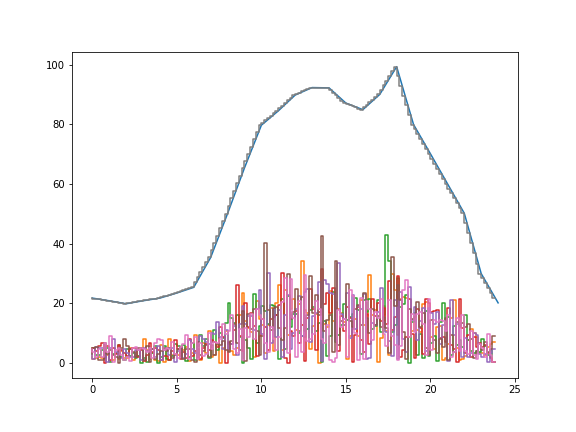

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
axes.plot(shapes['com']['t'],shapes['com']['val'], label='$\omega_{coi}$')

for il in range(N_l):
    axes.step(times/3600,values_arr[:,il], label='$\omega_{coi}$')
axes.step(times/3600,np.sum(values_arr,axis=1), label='$\omega_{coi}$')


In [25]:
Δt_small = 0.1
Δt_mid = 1.0
Δt_large = times[1]-times[0]
loads = values_arr*1000

it = 0
# simulate one large step
params_loads = {
'p_load_B2_a': loads[it,0],'p_load_B2_b':loads[it,1],'p_load_B2_c':loads[it,2],
'p_load_B3_a': loads[it,3],'p_load_B3_b':loads[it,4],'p_load_B3_c':loads[it,5]}

grid.ini(params_loads)

#it = 0
for it,t in enumerate(times):
            
    # simulate one large step
    params_loads = {
    'p_load_B2_a': loads[it,0],'p_load_B2_b':loads[it,1],'p_load_B2_c':loads[it,2],
    'p_load_B3_a': loads[it,3],'p_load_B3_b':loads[it,4],'p_load_B3_c':loads[it,5]}
    
    grid.Dt = Δt_small
    grid.run(t-Δt_large+10,params_loads)
    
    grid.Dt = Δt_mid
    grid.run(t,params_loads)

    
grid.post();

In [221]:
len(grid.Time)

98670

In [222]:
100*24*6+23*3600

97200

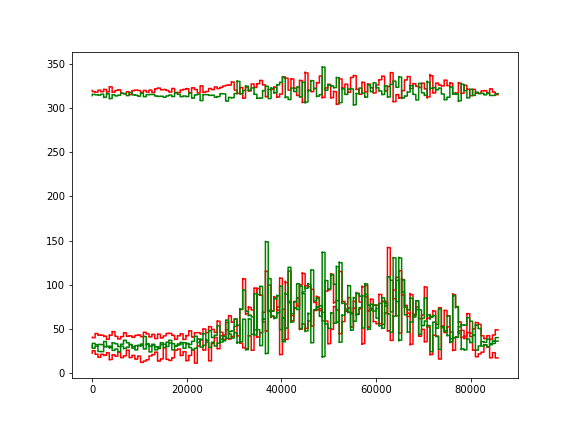

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
vsc = 'B1'
for ph in ['a','b','c']:
    axes.plot(grid.Time,grid.get_values(f"i_vsc_{vsc}_{ph}_m"), 'r',label='$\omega_{coi}$')
vsc = 'B4'
for ph in ['a','b','c']:
    axes.plot(grid.Time,grid.get_values(f"i_vsc_{vsc}_{ph}_m"), 'g',label='$\omega_{coi}$')

#axes.plot(times,loads, label='$\omega_{coi}$')


In [85]:
def get_i_l(grid,bus_j,bus_k,phase):
    i_l_r,i_l_i = grid.get_mvalue([f'i_l_{bus_j}_{bus_k}_{phase}_r',f'i_l_{bus_j}_{bus_k}_{phase}_i'])
    return i_l_r + 1j*i_l_i

def get_il(grid,bus_j,bus_k,phase):
    i_l_r = grid.get_values(f'i_l_{bus_j}_{bus_k}_{phase}_r')
    i_l_i = grid.get_values(f'i_l_{bus_j}_{bus_k}_{phase}_i')
    return i_l_r + 1j*i_l_i

def get_v(grid,bus,phase):
    v_r,v_i = grid.get_mvalue([f'v_{bus}_{phase}_r',f'v_{bus}_{phase}_i'])
    return v_r + 1j*v_i

def get_vs(grid,bus,phase):
    v_r = grid.get_values(f'v_{bus}_{phase}_r')
    v_i = grid.get_values(f'v_{bus}_{phase}_i')
    return v_r + 1j*v_i

def get_vns(grid,bus,phase):
    v_r = grid.get_values(f'v_{bus}_{phase}_r')
    v_i = grid.get_values(f'v_{bus}_{phase}_i')
    v_nr = grid.get_values(f'v_{bus}_n_r')
    v_ni = grid.get_values(f'v_{bus}_n_i')
    v_ph = v_r + 1j*v_i
    v_n  = v_nr + 1j*v_ni 
    return v_ph - v_n 

np.abs(get_vns(grid,'B4','a'))

array([0., 0., 0., ..., 0., 0., 0.])

In [10]:
grid.report_z()

v_B2_a_m = 231.47
v_B2_b_m = 231.47
v_B2_c_m = 231.47
v_B2_n_m =  0.00
v_B3_a_m = 230.96
v_B3_b_m = 230.96
v_B3_c_m = 230.96
v_B3_n_m =  0.00
v_B1_a_m = 231.40
v_B1_b_m = 231.40
v_B1_c_m = 231.40
v_B1_n_m =  0.00
v_B4_a_m = 230.89
v_B4_b_m = 230.89
v_B4_c_m = 230.89
v_B4_n_m =  0.00
i_vsc_B1_a_m = 21.72
i_vsc_B1_b_m = 21.72
i_vsc_B1_c_m = 21.72
i_vsc_B1_n_m =  0.00
p_B1_pos = -14977.45
p_B1_neg = -0.00
p_B1_zer = -0.00
e_B1_an = 230.94
e_B1_bn = 230.94
e_B1_cn = 230.94
p_B1_ref =  0.00
omega_B1_ref =  1.00
i_vsc_B4_a_m = 21.77
i_vsc_B4_b_m = 21.77
i_vsc_B4_c_m = 21.77
i_vsc_B4_n_m =  0.00
p_B4_pos = -14977.45
p_B4_neg = -0.00
p_B4_zer = -0.00
e_B4_an = 230.94
e_B4_bn = 230.94
e_B4_cn = 230.94
p_B4_ref =  0.00
omega_B4_ref =  1.00


In [9]:
grid = uac_4b4w2s.uac_4b4w2s_class()


xy_0_dict = {}
for bus in ['B1','B2','B3','B4']:
    for ph in ['a','b','c']:
        pass
        #xy_0_dict.update({f'v_{bus}_{ph}_r':grid.get_value(f'e_B1_{ph}n_r')}) 
        #xy_0_dict.update({f'v_{bus}_{ph}_i':grid.get_value(f'e_B1_{ph}n_i')}) 


#grid.load_0('xy_0_dict.json')
#grid.ss()

params = {'R_B1_ng':0.0,'X_B1_ng':0.001,'K_agc':5e6,
          'K_f_B1':-0.05,'K_f_B4':-0.05,
          'T_f_B1':0.1,'T_f_B4':0.1
         }
grid.ini(params,'xy_2_dict.json')
#grid.save_0('xy_1_dict.json')
#ssa.A_eval(grid)
#ssa.damp_report(grid)
#ssa.participation(grid).abs()
#grid.report_y()

grid.report_u()

p_load_B2_a =-0.00
q_load_B2_a =-0.00
p_load_B2_b =-0.00
q_load_B2_b =-0.00
p_load_B2_c =-0.00
q_load_B2_c =-0.00
p_load_B3_a =-0.00
q_load_B3_a =-0.00
p_load_B3_b =-0.00
q_load_B3_b =-0.00
p_load_B3_c =-0.00
q_load_B3_c =-0.00
e_B1_an =230.94
e_B1_bn =230.94
e_B1_cn =230.94
phi_B1 = 0.00
p_B1_ref = 0.00
omega_B1_ref = 1.00
e_B4_an =230.94
e_B4_bn =230.94
e_B4_cn =230.94
phi_B4 = 0.00
p_B4_ref = 0.00
omega_B4_ref = 1.00


In [35]:
grid = uac_4b4w2s.uac_4b4w2s_class()
grid.ini(params,'xy_2_dict.json')
grid.run( 1.0,{})
grid.run( 2.0,{'p_load_B2_a':-10e3,'p_load_B2_b':-10e3,'p_load_B2_c':-10e3 })
grid.run( 3.0,{'p_load_B2_a':-10e3,'p_load_B2_b':-10e3,'p_load_B2_c':-30e3 })
grid.run( 4.0,{'e_B1_cn':229})

grid.run(10.0,{})
grid.post();




In [36]:
bus_results

{'B1': {'v_B1_an': 231.1773682730357,
  'v_B1_bn': 231.1773682730357,
  'v_B1_cn': 231.89233414465951,
  'v_unb': 0.004212824903312294,
  'v_ng': 3.895569748028478},
 'B2': {'v_B2_an': 231.2892330268214,
  'v_B2_bn': 231.2892330268214,
  'v_B2_cn': 232.24098162809733,
  'v_unb': 0.005995699865350978,
  'v_ng': 3.978139573391586},
 'B3': {'v_B3_an': 231.14626833209084,
  'v_B3_bn': 231.14626833209084,
  'v_B3_cn': 229.47745513891894,
  'v_unb': 0.007907511786542845,
  'v_ng': 4.655784276246811},
 'B4': {'v_B4_an': 231.12756015031485,
  'v_B4_bn': 231.12756015031485,
  'v_B4_cn': 229.10967235970838,
  'v_unb': 0.009768556123955932,
  'v_ng': 4.777743631500135}}

In [13]:
grid.report_z()

v_B2_a_m = 230.94
v_B2_b_m = 230.94
v_B2_c_m = 230.94
v_B2_n_m =  0.00
v_B3_a_m = 230.94
v_B3_b_m = 230.94
v_B3_c_m = 230.94
v_B3_n_m =  0.00
v_B1_a_m = 230.94
v_B1_b_m = 230.94
v_B1_c_m = 230.94
v_B1_n_m =  0.00
v_B4_a_m = 230.94
v_B4_b_m = 230.94
v_B4_c_m = 230.94
v_B4_n_m =  0.00
i_vsc_a_m =  0.00
i_vsc_b_m =  0.00
i_vsc_c_m =  0.00
p_B1_pos = -0.00
p_B1_neg = -0.00
p_B1_zer =  0.00
e_B1_an = 230.94
e_B1_bn = 230.94
e_B1_cn = 229.00
p_B1_ref =  0.00
omega_B1_ref =  1.00
p_B4_pos = -0.00
p_B4_neg = -0.00
p_B4_zer =  0.00
e_B4_an = 230.94
e_B4_bn = 230.94
e_B4_cn = 230.94
p_B4_ref =  0.00
omega_B4_ref =  1.00


In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
#axes[0,0].plot(grid.T,np.abs(get_il(grid,'B1','B2','a')), label='$i_{a}$')
#axes[0,0].plot(grid.T,np.abs(get_il(grid,'B1','B2','b')), label='$i_{b}$')
#axes[0,0].plot(grid.T,np.abs(get_il(grid,'B1','B2','a')), label='$i_{c}$')
#axes[0,0].plot(grid.T,np.abs(get_il(grid,'B1','B2','n')), label='$i_{n}$')

#axes[0,0].plot(grid.T,grid.get_values('omega_B1'), label='$\omega_{B1}$')
#axes[0,0].plot(grid.T,grid.get_values('omega_B2'), label='$\omega_{B2}$')
axes[0,0].plot(grid.Time,grid.get_values('omega_coi'), label='$\omega_{coi}$')

for bus in ['B1','B2']:
    for ph in ['a','b','c']:
        axes[1,0].plot(grid.Time,np.abs(get_vs(grid,bus,ph)), label=f'{bus}: $v_{ph}$')

axes[0,1].plot(grid.Time, grid.get_values('p_B1_pos'), label='B1: $p^{+}$')
axes[1,1].plot(grid.Time, grid.get_values('p_B1_neg'), label='B1: $p^{-}$')
axes[0,1].plot(grid.Time, grid.get_values('p_B4_pos'), label='B4: $p^{+}$')
axes[1,1].plot(grid.Time, grid.get_values('p_B4_neg'), label='B4: $p^{-}$')
#axes[0].plot(grid.T,np.abs(get_il(grid,'B4','B2','c')), label='$p_{B1}$')
#axes[0].plot(grid.T,np.abs(get_il(grid,'B4','B2','n')), label='$p_{B1}$')

for ax in axes.flatten():
    ax.grid()
    ax.legend()
ax.set_xlabel('Time (s)')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'Time (s)')

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
axes[0].plot(grid.Time,np.abs(i_B1_a_r+1j*i_B1_a_i), label='$i_{a}$')
axes[0].plot(grid.Time,np.abs(i_B1_b_r+1j*i_B1_b_i), label='$i_{b}$')
axes[0].plot(grid.Time,np.abs(i_B1_c_r+1j*i_B1_c_i), label='$i_{c}$')
axes[0].plot(grid.Time,np.abs(i_B1_n_r+1j*i_B1_n_i), label='$i_{n}$')

axes[1].plot(grid.Time,np.abs(i_B4_a_r+1j*i_B4_a_i), label='$i_{a}$')
axes[1].plot(grid.Time,np.abs(i_B4_b_r+1j*i_B4_b_i), label='$i_{b}$')
axes[1].plot(grid.Time,np.abs(i_B4_c_r+1j*i_B4_c_i), label='$i_{c}$')
axes[1].plot(grid.Time,np.abs(i_B4_n_r+1j*i_B4_n_i), label='$i_{n}$')


for ax in axes.flatten():
    ax.grid()
    ax.legend()
ax.set_xlabel('Time (s)')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'Time (s)')

In [40]:
gt.report_v(grid,'uac_4b4w2s.json')

v_B1_an:   230.9|   -0.0º V,    v_B1_ag:   230.9|   -0.0º V,    v_1 =   230.9 V
v_B1_bn:   230.9| -120.0º V,    V_B1_bg:   230.9| -120.0º V,    v_2 =     0.0 V
v_B1_cn:   230.9|  120.0º V,    V_B1_cg:   230.9|  120.0º V,    v_0 =     0.0 V
  V_B1_ng:      0.0|   -169.0º V
v_B2_an:   230.9|   -0.0º V,    v_B2_ag:   230.9|   -0.0º V,    v_1 =   230.9 V
v_B2_bn:   230.9| -120.0º V,    V_B2_bg:   230.9| -120.0º V,    v_2 =     0.0 V
v_B2_cn:   230.9|  120.0º V,    V_B2_cg:   230.9|  120.0º V,    v_0 =     0.0 V
  V_B2_ng:      0.0|   -170.8º V
v_B3_an:   230.9|   -0.0º V,    v_B3_ag:   230.9|   -0.0º V,    v_1 =   230.9 V
v_B3_bn:   230.9| -120.0º V,    V_B3_bg:   230.9| -120.0º V,    v_2 =     0.0 V
v_B3_cn:   230.9|  120.0º V,    V_B3_cg:   230.9|  120.0º V,    v_0 =     0.0 V
  V_B3_ng:      0.0|   -178.7º V
v_B4_an:   230.9|   -0.0º V,    v_B4_ag:   230.9|   -0.0º V,    v_1 =   230.9 V
v_B4_bn:   230.9| -120.0º V,    V_B4_bg:   230.9| -120.0º V,    v_2 =     0.0 V
v_B4_cn:   230.9|  12

In [24]:
grid.report_y()

v_B2_a_r = 234.19
v_B2_a_i =  4.82
v_B2_b_r = -110.89
v_B2_b_i = -199.03
v_B2_c_r = -119.20
v_B2_c_i = 200.07
v_B2_n_r =  3.29
v_B2_n_i =  2.18
v_B3_a_r = 233.84
v_B3_a_i =  4.68
v_B3_b_r = -110.89
v_B3_b_i = -198.54
v_B3_c_r = -118.16
v_B3_c_i = 199.60
v_B3_n_r =  2.60
v_B3_n_i =  2.75
v_B1_a_r = 234.12
v_B1_a_i =  4.77
v_B1_b_r = -110.88
v_B1_b_i = -198.97
v_B1_c_r = -119.00
v_B1_c_i = 199.91
v_B1_n_r =  3.16
v_B1_n_i =  2.24
v_B4_a_r = 233.77
v_B4_a_i =  4.66
v_B4_b_r = -110.89
v_B4_b_i = -198.44
v_B4_c_r = -117.95
v_B4_c_i = 199.50
v_B4_n_r =  2.46
v_B4_n_i =  2.86
i_load_B2_a_r = 43.30
i_load_B2_a_i =  0.49
i_load_B2_b_r = -21.33
i_load_B2_b_i = -37.59
i_load_B2_c_r = -67.84
i_load_B2_c_i = 109.61
i_load_B2_n_r = 45.87
i_load_B2_n_i = -72.51
i_load_B3_a_r =  0.00
i_load_B3_a_i = -0.00
i_load_B3_b_r = -0.00
i_load_B3_b_i = -0.00
i_load_B3_c_r = -0.00
i_load_B3_c_i =  0.00
i_load_B3_n_r =  0.00
i_load_B3_n_i =  0.00
i_B1_a_r = -23.05
i_B1_b_r =  9.71
i_B1_c_r = 28.46
i_B1_n_r = -25.

In [10]:
grid_ss =  oc_4bus4wire2src_class()
grid_ss.initialize([params],'xy_2_dict.json')

class opt_class:
    
    def __init__(self,grid):
        self.grid = grid    
        V_n = 400/np.sqrt(3)
        self.x_0 = np.array([V_n]*6)
        
        self.bounds = [(0.95*V_n,1.05*V_n)]*6
        
    def optimize(self):
            
        #res = sopt.minimize(opt.obj_eval, x0, method='trust-constr', bounds=bounds)  # SLSQP, Powell, COBYLA,trust-constr
        cons_1 = {'type':'ineq','fun':opt.cons_1}
        cons = [cons_1]
        res = sopt.minimize(opt.obj_eval, self.x_0, method='trust-constr', bounds=self.bounds, 
                            constraints=cons)  # SLSQP, Powell, COBYLA,trust-constr
        self.res = res
        self.x_0 = res.x 
        return res.x
        
    
    def obj_eval(self,u):
        self.grid.load_0('xy_2_dict.json')

        self.grid.set_value('e_B1_an',u[0])
        self.grid.set_value('e_B1_bn',u[1])
        self.grid.set_value('e_B1_cn',u[2])
        self.grid.set_value('e_B4_an',u[3])
        self.grid.set_value('e_B4_bn',u[4])
        self.grid.set_value('e_B4_cn',u[5])
               
        self.grid.ss()

        P_B1 = self.grid.get_value('p_B1_pos')
        P_B4 = self.grid.get_value('p_B4_pos')
        P_B2 = self.grid.get_value('p_B2_a') + self.grid.get_value('p_B2_b') + self.grid.get_value('p_B2_c')

        P_loss = P_B1 + P_B4 + P_B2
        
        self.P_loss = P_loss
        return P_loss

    def cons(self,u):
         
        return {'type':'ineq','fun':self.cons_1(u)}

    def cons_1(self,u):
        self.grid.load_0('xy_2_dict.json')

        self.grid.set_value('e_B1_an',u[0])
        self.grid.set_value('e_B1_bn',u[1])
        self.grid.set_value('e_B1_cn',u[2])
        self.grid.set_value('e_B4_an',u[3])
        self.grid.set_value('e_B4_bn',u[4])
        self.grid.set_value('e_B4_cn',u[5])
               
        self.grid.ss()

        V_B1_a = np.abs(self.grid.get_value('v_B1_a_r') + 1j*self.grid.get_value('v_B1_a_i'))
        
        return 1.05*231-V_B1_a
    
opt = opt_class(grid_ss)

u = [400/np.sqrt(3)]*6
opt.obj_eval(u)
opt.cons(u)
opt.optimize()
opt.res

 barrier_parameter: 2.048000000000001e-09
 barrier_tolerance: 2.048000000000001e-09
          cg_niter: 552
      cg_stop_cond: 4
            constr: [array([11.69406389]), array([230.94359779, 230.91698741, 230.92861643, 230.87620478,
       230.96907591, 230.94385297])]
       constr_nfev: [1092, 0]
       constr_nhev: [0, 0]
       constr_njev: [0, 0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 3.2339658737182617
               fun: -2.3420757808049982e-07
              grad: array([0.00156971, 0.0011873 , 0.00115571, 0.00184864, 0.00106652,
       0.00212492])
               jac: [array([[ 0.01435667, -0.30010218, -0.24077664, -1.0143565 ,  0.30010259,
         0.24077647]]), array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])]
   lagrangian_grad: array([0.00154668, 0.00116626, 0.00113583, 0.00180951, 0.00105425,


In [11]:
grid = oc_4bus4wire2src_class()    # for time domain simulation
grid_ss = oc_4bus4wire2src_class() # for steady state optimization

params_ctrl = params.copy()
params_ctrl.update({'Dt':0.01,'decimation':1,'p_B2_a':-100e3,'p_B2_b':-100e3,'p_B2_c':-100e3})
grid.initialize([params_ctrl],'xy_2_dict.json',compile=True)
grid_ss.initialize([params_ctrl],'xy_2_dict.json',compile=True)

p_B2_a_0 = grid.get_value('p_B2_a')
p_B2_b_0 = grid.get_value('p_B2_b')
p_B2_c_0 = grid.get_value('p_B2_c')

opt = opt_class(grid_ss)
opt.grid.set_value('p_B2_a',p_B2_a_0)
opt.grid.set_value('p_B2_b',p_B2_b_0)
opt.grid.set_value('p_B2_c',p_B2_c_0)
u = opt.optimize()

grid.set_value('e_B1_an',u[0])
grid.set_value('e_B1_bn',u[1])
grid.set_value('e_B1_cn',u[2])
grid.set_value('e_B4_an',u[3])
grid.set_value('e_B4_bn',u[4])
grid.set_value('e_B4_cn',u[5])
grid.initialize([params_ctrl],'xy_2_dict.json',compile=True)

Δt = 1
t_end = 10.0

times = np.arange(0,t_end+Δt,Δt)

for t in times:
    
    # events
    p_B2_a = p_B2_a_0
    p_B2_b = p_B2_b_0
    p_B2_c = p_B2_c_0
    if t>2.0:
        p_B2_a = 2*p_B2_a_0
        p_B2_b = 2*p_B2_b_0
        p_B2_c = 2*p_B2_c_0
    if t>6.0:
        p_B2_a = 2*p_B2_a_0
        p_B2_b = 1*p_B2_b_0
        p_B2_c = 2*p_B2_c_0
        
    # simulate one large step
    grid.run([{'t_end': t,'p_B2_a':p_B2_a,'p_B2_b':p_B2_b,'p_B2_c':p_B2_c}])
    
    # update ss system
    opt.grid.set_value('p_B2_a',p_B2_a)
    opt.grid.set_value('p_B2_b',p_B2_b)
    opt.grid.set_value('p_B2_c',p_B2_c)
    
    # update inputs in main system
    u = opt.optimize()      
    
    if opt.res.success:
        grid.set_value('e_B1_an',u[0])
        grid.set_value('e_B1_bn',u[1])
        grid.set_value('e_B1_cn',u[2])
        grid.set_value('e_B4_an',u[3])
        grid.set_value('e_B4_bn',u[4])
        grid.set_value('e_B4_cn',u[5])
    print(f't={t:0.1f}, p_loss = {opt.P_loss:0.5f}')
               
grid.post();

t=0.0, p_loss = 3111.54628
t=1.0, p_loss = 3111.54622
t=2.0, p_loss = 3111.54555
t=3.0, p_loss = 13211.40382
t=4.0, p_loss = 13211.40048
t=5.0, p_loss = 13211.40377
t=6.0, p_loss = 13211.40382
t=7.0, p_loss = 3987.46368
t=8.0, p_loss = 3987.46368
t=9.0, p_loss = 3987.46367
t=10.0, p_loss = 3987.46367


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

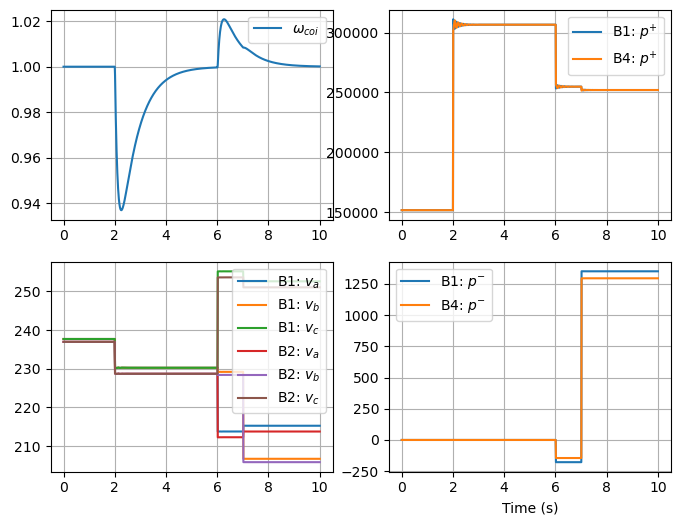

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
#axes[0,0].plot(grid.T,np.abs(get_il(grid,'B1','B2','a')), label='$i_{a}$')
#axes[0,0].plot(grid.T,np.abs(get_il(grid,'B1','B2','b')), label='$i_{b}$')
#axes[0,0].plot(grid.T,np.abs(get_il(grid,'B1','B2','a')), label='$i_{c}$')
#axes[0,0].plot(grid.T,np.abs(get_il(grid,'B1','B2','n')), label='$i_{n}$')

#axes[0,0].plot(grid.T,grid.get_values('omega_B1'), label='$\omega_{B1}$')
#axes[0,0].plot(grid.T,grid.get_values('omega_B2'), label='$\omega_{B2}$')
axes[0,0].plot(grid.T,grid.get_values('omega_coi'), label='$\omega_{coi}$')

for bus in ['B1','B2']:
    for ph in ['a','b','c']:
        axes[1,0].plot(grid.T,np.abs(get_vs(grid,bus,ph)), label=f'{bus}: $v_{ph}$')

axes[0,1].plot(grid.T, grid.get_values('p_B1_pos'), label='B1: $p^{+}$')
axes[1,1].plot(grid.T, grid.get_values('p_B1_neg'), label='B1: $p^{-}$')
axes[0,1].plot(grid.T, grid.get_values('p_B4_pos'), label='B4: $p^{+}$')
axes[1,1].plot(grid.T, grid.get_values('p_B4_neg'), label='B4: $p^{-}$')
#axes[0].plot(grid.T,np.abs(get_il(grid,'B4','B2','c')), label='$p_{B1}$')
#axes[0].plot(grid.T,np.abs(get_il(grid,'B4','B2','n')), label='$p_{B1}$')

for ax in axes.flatten():
    ax.grid()
    ax.legend()
ax.set_xlabel('Time (s)')

fig

In [13]:
svg1 = svg('grid_4bus.svg')
svg1.set_size(800,600)


for ph in ['a','b','c','n']:
    i = np.abs(get_i_l(grid,'B1','B2',ph))
    svg1.set_text(f'i_B1_B2_{ph}_m',f' {i:4.0f} A')
    i = np.abs(get_i_l(grid,'B2','B3',ph))
    svg1.set_text(f'i_B2_B3_{ph}_m',f' {i:0.0f} A')
    i = np.abs(get_i_l(grid,'B3','B4',ph))
    svg1.set_text(f'i_B3_B4_{ph}_m',f' {i:0.0f} A')

p_load = 0
for item in gt_grid.buses:
    if item['bus'] == 'B2': break
for ph in ['a','b','c']:
    svg1.set_text(f'S_B2_{ph}',f"= {-item[f'p_{ph}']/1000:0.0f} + j{item[f'q_{ph}']/1000+0.01:0.0f} kVA")    
    p_load += item[f'p_{ph}']
for item in gt_grid.buses:
    if item['bus'] == 'B3': break
for ph in ['a','b','c']:
    svg1.set_text(f'S_B3_{ph}',f"= {-item[f'p_{ph}']/1000:0.0f} + j{item[f'q_{ph}']/1000+0.01:0.0f} kVA")    
    p_load += item[f'p_{ph}']

for item in gt_grid.buses:
    if item['bus'] == 'B1': break
p,q = 0.0,0.0
for ph in ['a','b','c']:
    p += item[f'p_{ph}']
    q += item[f'q_{ph}']    
svg1.set_text(f'P_B1',f"= {p/1000:0.1f} kW") 
svg1.set_text(f'Q_B1',f"= {q/1000:0.0f} kvar")   
svg1.set_text(f'S_B1',f"= {np.abs(p+1j*q)/1000:0.0f} kVA")  
svg1.set_text(f'U_B1',f"= {item['v_ab']:0.0f}∠{np.rad2deg(grid.theta_B1)+0.01:0.1f}º V")

for item in gt_grid.buses:
    if item['bus'] == 'B4': break
p,q = 0.0,0.0
for ph in ['a','b','c']:
    p += item[f'p_{ph}']
    q += item[f'q_{ph}']    
svg1.set_text(f'P_B4',f"= {p/1000:0.1f} kW") 
svg1.set_text(f'Q_B4',f"= {q/1000:0.0f} kvar")   
svg1.set_text(f'S_B4',f"= {np.abs(p+1j*q)/1000:0.0f} kVA")  
svg1.set_text(f'U_B4',f"= {item['v_ab']:0.0f}∠{np.rad2deg(grid.theta_B4)+0.01:0.1f}º V")

svg1.set_text(f'P_loss',f"= {grid.p_total+p_load:0.0f} W")
svg1.save('grid_4bus_2.svg')
HTML('grid_4bus_2.svg')

NameError: name 'gt_grid' is not defined

In [143]:
grid = oc_4bus4wire2src_class()
params_id = params.copy()
Δt = 0.01

params_id.update({'T_f_B1':1,'T_f_B4':1, 'Dt':Δt, 'decimation':1})
grid.initialize([params_id],'xy_2_dict.json')
A = ssa.eval_A(grid)
grid.run([{'t_end':1.0}])
grid.run([{'t_end':2.0,'p_B1_ref':10e3 }])
grid.run([{'t_end':4.0,'p_B4_ref':10e3 }])
grid.run([{'t_end':20.0}])
grid.post();



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

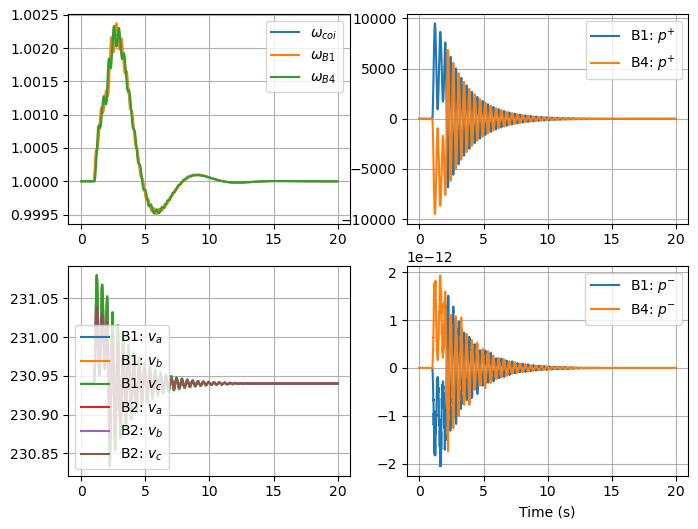

In [144]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
axes[0,0].plot(grid.T,grid.get_values('omega_coi'), label='$\omega_{coi}$')
axes[0,0].plot(grid.T,grid.get_values('omega_B1'), label='$\omega_{B1}$')
axes[0,0].plot(grid.T,grid.get_values('omega_B4'), label='$\omega_{B4}$')

for bus in ['B1','B2']:
    for ph in ['a','b','c']:
        axes[1,0].plot(grid.T,np.abs(get_vs(grid,bus,ph)), label=f'{bus}: $v_{ph}$')

axes[0,1].plot(grid.T, grid.get_values('p_B1_pos'), label='B1: $p^{+}$')
axes[1,1].plot(grid.T, grid.get_values('p_B1_neg'), label='B1: $p^{-}$')
axes[0,1].plot(grid.T, grid.get_values('p_B4_pos'), label='B4: $p^{+}$')
axes[1,1].plot(grid.T, grid.get_values('p_B4_neg'), label='B4: $p^{-}$')
#axes[0].plot(grid.T,np.abs(get_il(grid,'B4','B2','c')), label='$p_{B1}$')
#axes[0].plot(grid.T,np.abs(get_il(grid,'B4','B2','n')), label='$p_{B1}$')

for ax in axes.flatten():
    ax.grid()
    ax.legend()
ax.set_xlabel('Time (s)')

fig

In [188]:
import sid 

omega_coi = grid.get_values('omega_coi')*0+1
u = np.vstack([grid.get_values('p_B1_ref'),grid.get_values('p_B4_ref')])
z = np.vstack([grid.get_values('omega_B1')-omega_coi,grid.get_values('omega_B4')-omega_coi])
###############################################################################
# model estimation and validation

# estimate the Markov parameters
past_value=10 # this is the past window - p 
Markov,Z, Y_p_p_l = sid.estimateMarkovParameters(u,z,past_value)

# estimate the system matrices
model_order=5 # this is the model order \hat{n}
Aid,Atilde,Bid,Kid,Cid,s_singular,X_p_p_l = sid.estimateModel(u,z,Markov,Z,past_value,past_value,model_order)  

plt.plot(s_singular, 'x',markersize=8)
plt.xlabel('Singular value index')
plt.ylabel('Singular value magnitude')
plt.yscale('log')
#plt.savefig('singular_values.png')
plt.show()

# estimate the initial state of the validation data
h=10 # window for estimating the initial state
x0est=sid.estimateInitial(Aid,Bid,Cid,u,z,h)

In [227]:
#### import ssid


NumURows = 10
NumUCols = 2000
NumU = 2 * NumURows + NumUCols - 1

AID,BID,CID,DID,CovID,S = ssid.N4SID(u.T,z.T,NumURows,NumUCols,4,require_stable=True)


TypeError: 'float' object cannot be interpreted as an integer

In [219]:
NumUCols

2000

In [205]:
K_id = 10e3
T_p = 5.0
fh = 5
times = np.arange(0,10+Δt,Δt)


den = 2*np.pi*fh*(times-T_p)                 
Dp =  K_id*np.sin(2*np.pi*fh*(times-T_p))/den 

<ipython-input-205-6371e8f3cd4c>:7: RuntimeWarning: invalid value encountered in true_divide
  Dp =  K_id*np.sin(2*np.pi*fh*(times-T_p))/den


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

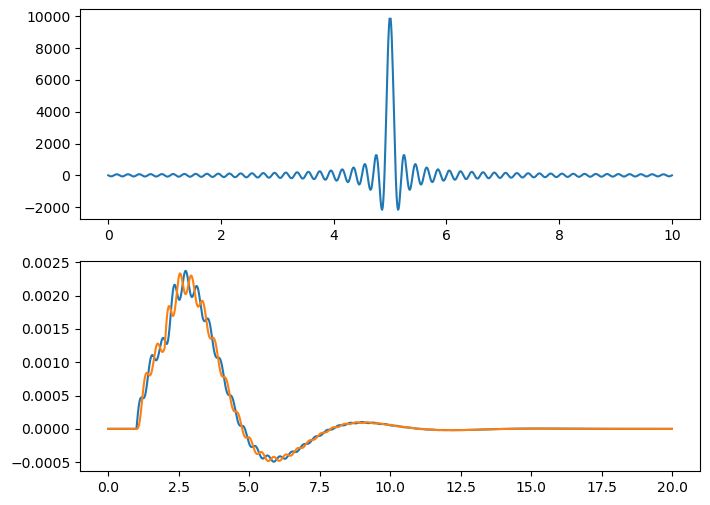

In [206]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
axes[0].plot(times,Dp, label='$\omega_{coi}$')
#axes[0].plot(grid.T,u.T, label='$\omega_{coi}$')
axes[1].plot(grid.T,z.T, label='$\omega_{B4}$')
fig

In [190]:
I=np.identity(Aid.shape[0]) # this is an identity matrix
# A=inv(I-sampling*Ac)
Ac = (np.linalg.inv(Aid) - I)/Δt
#B=A*sampling*Bc
#C=Cc

In [191]:
E_id = np.linalg.eig(Aid)[0]
E_cont = np.log(E_id)/Δt
E_cont

array([-4.29540857e+02+314.15926536j, -4.61266502e-01 +14.31887122j,
       -4.61266502e-01 -14.31887122j, -3.28023493e-01  +0.92084525j,
       -3.28023493e-01  -0.92084525j])

In [192]:
np.linalg.eig(A)[0]

array([-5.00250001e-01+15.10348879j, -5.00250001e-01-15.10348879j,
       -4.99998906e-04 +0.j        , -5.00000000e-01 +1.j        ,
       -5.00000000e-01 -1.j        ])

In [237]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy.signal as sp
import numpy.random as rnd
import ssid

# Just a helper for defining plants
def generalizedPlant(A,B,C,D,Cov,dt):
    CovChol = la.cholesky(Cov,lower=True)
    NumStates = len(A)

    B1 = CovChol[:NumStates,:]
    B2 = B

    Bbig = np.hstack((B1,B2))

    D1 = CovChol[NumStates:,:]
    D2 = D
    Dbig = np.hstack((D1,D2))

    P = (A,Bbig,C,Dbig,dt)
    return P


# Generate an input to the plant.
# Here we are using two independent Ornstein-Uhlenbeck processes.
theta = .001
AU = (1- dt * theta) * np.eye(NumInputs)
BU = 10 * np.eye(NumInputs) * np.sqrt(dt)
CU = np.eye(NumInputs)
DU = np.zeros((NumInputs,NumInputs)) / np.sqrt(dt)
# Sampling rate of 1
USys = (AU,BU,CU,DU,dt)
NumURows = 10
NumUCols = 2000
NumU = 2 * NumURows + NumUCols - 1
Time = np.arange(NumU)
uu = rnd.randn(NumU,NumInputs)
# u is the actual input
tu,u,xu = sp.dlsim(USys,uu)

# Define the plant. Here it is a coupled spring-mass-damper system with forces and position measurements.
dt = .1
k1 = 1.
k2 = 2.
c1 = 2.
c2 = 2.
m1 = 1.
m2 = 1.
Kmat = np.array([[k1+k2,-k2],
                 [-k2,k2]])
Cmat = np.diag([c1,c2])

Mmat  = np.diag([m1,m2])


Ac = np.zeros((4,4))

Ac[:2,2:] = np.eye(2)
Ac[2:,:2] = -la.solve(Mmat,Kmat,sym_pos=True)
Ac[2:,2:] = -la.solve(Mmat,Cmat,sym_pos=True)
A = np.eye(4) + dt * Ac

Bc = np.zeros((4,2))
Bc[2:] = la.inv(Mmat)


B = dt * Bc
C = np.zeros((2,4))
C[:,:2] = np.eye(2)

NumInputs = B.shape[1]
NumOutputs = C.shape[0]

D = np.zeros((NumOutputs,NumInputs))

NumStates = len(A)
NumOutputs,NumInputs = D.shape

Q = .1 * np.eye(NumStates) * dt 
S = np.zeros((NumStates,NumOutputs))
R = .1 * np.eye(NumOutputs) / dt

CovTop = np.hstack((Q,S))
CovBot = np.hstack((S.T,R))
Cov = np.vstack((CovTop,CovBot))

P = generalizedPlant(A,B,C,D,Cov,dt)


# Simulate the plant with the generated input as well as noise
w = rnd.randn(NumU,NumStates+NumOutputs)
bigU = np.hstack((w,u))
tout,y,xout = sp.dlsim(P,bigU)
plt.plot(tout,u)
plt.plot(tout,y)





# Generate an input to the plant.
# Here we are using two independent Ornstein-Uhlenbeck processes.
theta = .001
AU = (1- dt * theta) * np.eye(NumInputs)
BU = 10 * np.eye(NumInputs) * np.sqrt(dt)
CU = np.eye(NumInputs)
DU = np.zeros((NumInputs,NumInputs)) / np.sqrt(dt)
# Sampling rate of 1
USys = (AU,BU,CU,DU,dt)
NumURows = 10
NumUCols = 2000
NumU = 2 * NumURows + NumUCols - 1
Time = np.arange(NumU)
uu = rnd.randn(NumU,NumInputs)
# u is the actual input
tu,u,xu = sp.dlsim(USys,uu)

# Identify matrices using the Standard N4SID algorithm
AID,BID,CID,DID,CovID,S = ssid.N4SID(u.T,y.T,NumURows,NumUCols,4)
# For conistency with the Subspace ID literature, 
# we transpose the signals so that each input and output instance is a column vector
# This is opposite from the lsim convention

# Check the singular values
plt.plot(S / S.sum())

# Check how the computed impulse resonse compares.
plt.figure()
NhSteps = 200
tout,hTrue = sp.dimpulse((A,B,C,D,dt),t=dt * np.arange(NhSteps))
tout,hID = sp.dimpulse((AID,BID,CID,DID,dt),t=dt*np.arange(NhSteps))
for i in range(NumOutputs):
    for j in range(NumInputs):
        plt.figure()
        plt.plot(tout,hTrue[j][:,i])
        plt.plot(tout,hID[j][:,i])

TypeError: 'float' object cannot be interpreted as an integer

In [238]:
grid.initialize([{'p_B2_a':-30e3,'p_B2_b':-30e3,'p_B2_c':-30e3,
                  'p_B3_a':-10e3,'p_B3_b':-10e3,'p_B3_c':-10e3}],xy0='xy_0_dict.json')
Δt = 100.0e-3
Times = np.arange(0,6.0,Δt)

it = 0
t_0 = time.time()

for t in Times:  
    p_B3_c = -10.0e3
    if t>1.0: p_B3_c = -70.0e3
    
    grid.set_value('p_B3_c', p_B3_c)
    
    sopt.minimize(obj,[0]*7,method='Powell',bounds=[(-1,1)]*7) # SLSQP, Powell
    grid.run([{'t_end':t}])


grid.post();

initialization not found!


NameError: name 'obj' is not defined

In [ ]:
plt.close('all')
fig, axes = plt.subplots(nrows=4,ncols=1, figsize=(5, 8), frameon=False, dpi=100, squeeze=False)

it = 0
for ph in ['a','b','c','n']:
    i_m = np.abs(grid.get_values(f'i_l_B1_B2_{ph}_r') + 1j*grid.get_values(f'i_l_B1_B2_{ph}_i'))
    axes[it,0].plot(grid.T, i_m, label="$DV_{B1}$ (LV)")
    it+=1
    
it = 0
for ph in ['a','b','c','n']:
    i_m = np.abs(grid.get_values(f'i_l_B3_B4_{ph}_r') + 1j*grid.get_values(f'i_l_B3_B4_{ph}_i'))
    axes[it,0].plot(grid.T, i_m, label="$DV_{B1}$ (LV)")
    it+=1

In [15]:
gt_grid = gt.grid(grid)
gt_grid.dae2vi()
gt_grid.get_v()
gt_grid.get_i()
gt_grid.bokeh_tools()
gt.plot_results(gt_grid)

Figure(id='1003', ...)

In [ ]:
sol = sopt.minimize(obj,[0]*8,method='Powell',bounds=[(-1,1)]*8) # SLSQP, Powell
sol
phases = ['a','b','c','n']
print(f'B1:       --- B4:          ')
for ph in phases:
    I_B1 = np.abs(i_l(grid,'B1','B2',ph))
    I_B4 = np.abs(i_l(grid,'B3','B4',ph))

    print(f'I_{ph} = {I_B1:3.0f} --- I_{ph} = {I_B4:3.0f}')
    
p, epsilon = obj(sol.x,report=True)
print(f'Ploss = {p-180e3:0.1f} W')

In [ ]:


events = [{ # CTRL4-3-0
           't_end':0.0, 
                     },
          {'t_end':1.0}, 
          {'t_end':6.0},
          {'t_end':15.0}
          ]

with open('xy_0_dict.json') as fobj:
    data = json.loads(fobj.read().replace("'",'"'))
    
for item in data:
    syst.xy_prev[syst.y_ini_list.index(item)] = data[item]

In [16]:
V_b = 400/np.sqrt(3)
gt.set_voltages(syst,'B1',[V_b*1,V_b*1,V_b*1.0],0)
gt.set_voltages(syst,'B4',[V_b,V_b,V_b*1],0)
syst.initialization_tol = 1e-12

syst.initialize([{}],xy0='xy_0_dict.json')
t=0

In [8]:
t+=0.1
gt.set_voltages(syst,'B1',[V_b*1,V_b*1,V_b*1.005],0)
gt.set_voltages(syst,'B4',[V_b,V_b,V_b*0.995],0)
syst.run([{'t_end':t}])

grid_1 = gt.grid(syst)
grid_1.dae2vi()
grid_1.get_v()
grid_1.get_i()

phases = ['a','b','c','n']
print(f'B1:       --- B4:          ')
for it in range(4):
    I_B1 = float(np.abs(grid_1.I_lines[it]))
    I_B4 = float(np.abs(grid_1.I_lines[it+8]))

    print(f'I_{phases[it]} = {I_B1:3.0f} --- I_{phases[it]} = {I_B4:3.0f}')
    

grid_1.bokeh_tools()

gt.plot_results(grid_1)



NameError: name 't' is not defined

In [11]:
syst = grid_4bus4wire_class()
syst.Dt = 10e-3
syst.decimation = 1
syst.update()

Δt = 100.0e-3
Times = np.arange(0,6.0,Δt)

gt.set_voltages(syst,'B1',[V_b*1,V_b*1,V_b*1.0],0)
gt.set_voltages(syst,'B4',[V_b,V_b,V_b*1],0)

syst.initialize([{}],
               'xy_0_dict.json');

N_times = len(Times)

I_B1 = np.zeros((N_times,4))
I_B4 = np.zeros((N_times,4))

xi_V_B1 = np.zeros((N_times+1,4))
xi_V_B4 = np.zeros((N_times+1,4))

DV_B1 = np.zeros((N_times+1,4))
DV_B4 = np.zeros((N_times+1,4))

Dq_r_prev = 0.0

it = 0
t_0 = time.time()
for t in Times:
    
    # measurments
    grid_1 = gt.grid(syst)
    grid_1.dae2vi()
    grid_1.get_v()
    grid_1.get_i()

    phases = ['a','b','c','n']
    for iph in range(4):
        I_B1[it,iph] = float(np.abs(grid_1.I_lines[iph]))
        I_B4[it,iph] = float(np.abs(grid_1.I_lines[iph+8]))   

        
    # control
    for iph in range(3):
        I_B14 = I_B1[it,iph] - I_B4[it,iph]
        xi_V_B1[it+1,iph] = xi_V_B1[it,iph] + I_B14
        xi_V_B4[it+1,iph] = xi_V_B4[it,iph] - I_B14
        
        DV_B1[it+1,iph] = -0.0001*I_B14 -0.002*xi_V_B1[it+1,iph]
        DV_B4[it+1,iph] =  0.0001*I_B14 -0.002*xi_V_B4[it+1,iph]

    
    gt.set_voltages(syst,'B1',[V_b+DV_B1[it,0],
                               V_b+DV_B1[it,1],
                               V_b+DV_B1[it,2]],0)
                               
    gt.set_voltages(syst,'B4',[V_b+DV_B4[it,0],
                               V_b+DV_B4[it,1],
                               V_b+DV_B4[it,2]],0)
    
    events = [{'t_end':t}]
    syst.run(events)
    
#    U_grid += [U_grid_pu]
#    U += [U_meas_pu]
#    Dq_r_list += [Dq_r]

    it +=1
syst.post();    

print(time.time()-t_0)

0.340087890625


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [14]:
plt.close('all')
fig, axes = plt.subplots(nrows=3,ncols=2, figsize=(10, 6), frameon=False, dpi=100, squeeze=False)

phases = ['a','b','c','n']
for iph in range(3):
    axes[iph,0].plot(Times, I_B1[:,iph], label="$DV_{B1}$ (LV)")
    axes[iph,0].plot(Times, I_B4[:,iph], label="$DV_{B1}$ (LV)")
    
    ph = phases[iph]
    
    axes[iph,1].plot(syst.T, syst.get_values(f'v_B1_{ph}_m'), label="$DV_{B1}$ (LV)")
    axes[iph,1].plot(syst.T, syst.get_values(f'v_B4_{ph}_m'), label="$DV_{B1}$ (LV)")
    
    axes[iph,0].grid()
    axes[iph,1].grid()

    axes[iph,0].plot(Times, I_B1[:,iph]*0+250, label="$DV_{B1}$ (LV)")
    axes[iph,1].plot(Times, I_B1[:,iph]*0+400/np.sqrt(3), label="$DV_{B1}$ (LV)")
    
    axes[iph,0].set_xlim([0,4])
    axes[iph,1].set_xlim([0,4])
    
    axes[iph,0].set_ylim([50,350])    
    axes[iph,1].set_ylim([400/np.sqrt(3)*0.99,400/np.sqrt(3)*1.01])    
    
    

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [72]:
grid_1.dae2vi()
grid_1.get_v()
grid_1.get_i()
grid_1.bokeh_tools()

gt.plot_results(grid_1)

Figure(id='1147', ...)

In [73]:
syst.report_z()

v_B1_a_m = 230.49
v_B1_b_m = 230.49
v_B1_c_m = 232.07
v_B4_a_m = 231.39
v_B4_b_m = 231.39
v_B4_c_m = 229.81
v_B2_a_m = 230.23
v_B2_b_m = 230.23
v_B2_c_m = 231.21
v_B2_n_m =  0.24
v_B3_a_m = 231.07
v_B3_b_m = 231.07
v_B3_c_m = 229.06
v_B3_n_m =  1.19
v_B1_n_m =  0.05
v_B4_n_m =  0.26


In [9]:
grid_1.V_node * grid_1.I_node

array([[-1.10945343e+05+5.63928367e+04j],
       [ 1.04270750e+05+6.79282110e+04j],
       [ 6.34095311e+03-1.33666658e+05j],
       [ 8.16323221e+04-3.74930862e+04j],
       [-7.33398876e+04-5.18840829e+04j],
       [-1.02765791e+04+2.97609703e+04j],
       [ 2.55002343e+04-1.58455313e+04j],
       [-2.64350769e+04-1.42009942e+04j],
       [ 9.61491272e+02+2.99542221e+04j],
       [-4.15622931e-03-2.19066132e-02j],
       [ 8.50680769e+03-5.31986175e+03j],
       [-8.80467657e+03-4.77576894e+03j],
       [ 2.64802982e+03+7.95608185e+04j],
       [ 7.79781805e+01+3.43095911e+02j],
       [ 0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j]])

In [7]:
310*690

213900